In [1]:
import csv
import linecache
import datetime
import sys
import numpy as np
import random
from scipy.sparse import *
from scipy import *
import scipy as sp
import matplotlib.pyplot as plt
import os.path
import matplotlib
import copy
import pandas as pd
from scipy import stats
from tempfile import TemporaryFile
import pickle
from scipy.integrate import odeint
from torchdiffeq import odeint as dodeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from scipy.stats import skew

def flushPrint(variable):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % variable)
    sys.stdout.flush() 

# Import data

## City data

In [2]:
df1=pd.read_csv('./data/county_city_province.csv')
cities1 = set((df1['CITY']))
df2=pd.read_csv('./data/citypopulation.csv')
cities2 =set((df2['city']))
cities = set(list(cities1) + list(cities2))
nodes = {}
city_properties = {}
id_city = {}
for ct in cities:
    nodes[ct] = len(nodes)
    city_properties[ct] = {'pop':1,'prov':'','id':-1}
for i in df2.iterrows():
    city_properties[i[1][0]] = {'pop':float(i[1][1])}
for i in df1.iterrows():
    dc = city_properties.get(i[1]['CITY'],{})
    dc['prov'] = i[1]['PROV']
    dc['id'] = i[1]['CITY_ID']
    city_properties[i[1]['CITY']]=dc
    id_city[dc['id']] = i[1]['CITY']

## Baidu migration flux ratio data (2016, 2020)

In [3]:
df=pd.read_csv('./data/city_flow_v1.csv')
flows = {}
for n,i in enumerate(df.iterrows()):
    if n % 1000 == 0:
        flushPrint(n/len(df))
    cityi=long(i[1]['cityi.id'])
    cityj=long(i[1]['cityj.id'])
    value = flows.get((cityi,cityj),0)
    flows[(cityi,cityj)] = value + i[1]['flowij']
    if cityi==341301:
        print(flows[(cityi,cityj)])
    
#save to flux matrix
matrix = np.zeros([len(nodes), len(nodes)])
self_flux = np.zeros(len(nodes))
pij1 = np.zeros([len(nodes), len(nodes)])
for key,value in flows.items():
    id1 = nodes.get(id_city[key[0]],-1)
    id2 = nodes.get(id_city[key[1]],-1)
    matrix[id1, id2] = value
for i in range(matrix.shape[0]):
    self_flux[i] = matrix[i, i]
    matrix[i, i] = 0
    if np.sum(matrix[i,:])>0:
        pij1[i,:]=matrix[i,:]/np.sum(matrix[i,:])


0.995342957403680654

In [4]:
df=pd.read_csv('./data/Pij_BAIDU.csv',encoding='gbk')
df.head(4)

cities = {d:i for i,d in enumerate(df['Cities'])}
pij2 = np.zeros([len(nodes), len(nodes)])
for k,ind in cities.items():
    row = df[k]
    for city,column in cities.items():
        i_indx = nodes.get(city, -1)
        if i_indx < 0:
            print(city)
        j_indx = nodes.get(k, -1)
        if j_indx < 0:
            print(k)
        if i_indx >=0 and j_indx >= 0:
            pij2[j_indx, i_indx] = row[column] / 100
            if i_indx == j_indx:
                pij2[i_indx, j_indx] = 0
#pij = pij2

bools = pij2 <= 0
pij = np.zeros([pij1.shape[0], pij1.shape[0]])
for i in range(pij1.shape[0]):
    row = pij1[i]
    bool1 = bools[i]
    values = row * bool1
    if np.sum(values) > 0:
        ratios = values / np.sum(values)
        sum2 = np.sum(pij2[i, :])
        pij[i,:] = (1 - sum2) * ratios + pij2[i, :]
zeros = np.argwhere(np.sum(pij, axis=1) == 0).reshape(-1)
for idx in zeros:
    pij[idx][idx] = 1

np.sum(pij,1) #Testing normalization


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

## Cases data

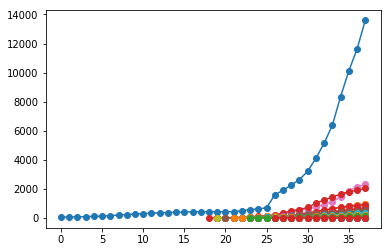

In [5]:
df = pd.read_csv('./data/R_cases_cum.csv',encoding='gbk')
df

all_cases_cities = list(set(df['city_name']))[1:]

wuhan=df.loc[df['city_name']=='武汉市',['confirm','time','heal','dead']]
dates = list(wuhan['time'])
sorted_dates = np.sort(dates)
first_date = datetime.datetime(2020, 1, 1, 0, 0)
first_cases = int(wuhan.loc[wuhan['time']=='2020-01-01']['confirm'])


all_cases = {}

for city in all_cases_cities:
    subset = df.loc[df['city_name']==city,['confirm','time','heal','dead']]
    zhixia = False
    
    new_cases = np.array(subset['confirm'])
    cued_cases = np.array(subset['heal'])
    die_cases = np.array(subset['dead'])
    dates = list(subset['time'])
    days = []
    for i,dd in enumerate(dates):
        if pd.isnull(dd):
            dd = dates1[i]
        if not pd.isnull(dd):
            days.append((datetime.datetime.strptime(dd,'%Y-%m-%d') - first_date).days)
    sorted_days = np.sort(days)
    indx = np.argsort(days)
    infected = new_cases[indx]
    cued = cued_cases[indx]
    death = die_cases[indx]
    bools =sorted_days>=0
    if len(sorted_days)>0:
        all_cases[city] = (sorted_days[bools], infected[bools], cued[bools], death[bools])


for case in all_cases.values():
    xx = case[0]
    yy = case[1]
    if len(yy) > 0:
        plt.plot(xx,yy,'o-')
#plt.semilogy()
plt.show()


# SICRD Model

The model can be described by:

$\partial i_n/\partial t = \frac{R_0}{T_L}i_n s_n - \frac{1}{T_L}i_n + \gamma \sum_{m\neq n}p_{nm}(i_m-i_n)$


$\partial c_n/\partial t = \frac{\alpha}{T_L} c_n - \frac{1}{T_I} c_n$



$\partial s_n/\partial t = -\frac{R_0}{T_L} i_n s_n + \gamma \sum_{m\neq n}p_{nm}(s_m-s_n)$


$r_n = 1 - s_n - j_n - l_n$

where $i_n$ is infection ratio of city n; 
$s_n$ is the susceptible ratio of city n; 
$c_n$ is the confirmed ratio of city n; 
$R_0$ is the basic reproductive number；
$T_I$ is the average time from confirmed to cure / death; 
$T_L$ is the average time from infected to confirm; 
$\gamma$ is the average ratio of migration population to the total population；
$p_{nm}$ is the migration ratio from city n to city m.

In our simulation, we use matrix and inner product to compute $\sum_{m\neq n}p_{nm}(x_m-x_n)$, also with some simplification, i.e., $\sum_{m\neq n}p_{nm}(x_m-x_n)=\sum_m p_{nm}x_m-x_n$ be $P\cdot \vec{x} - \vec{x}$, where $x$ is $l,j,s$, $\vec{x}=(x_1,x_2,...,x_N)$

In [54]:

def protect_decay(t, t0, eta, rate_time, relax):
    epsilon = 0.001
    r = 2 * np.log((1-epsilon)/epsilon) / rate_time
    x0 = t0 + rate_time/2
    decay = eta / (1 + np.exp(r * (t - x0))) + 1 - eta
    if relax>0:
        #tstar = x0 + np.log((1-relax*epsilon)/(relax*epsilon+eta-1))
        tstar = relax
        decay1 = eta/(1 + np.exp(r*(2*tstar - t - x0))) + 1 - eta
        decay = decay + decay1
    return decay
def diff(sicol, t, r_0, t_r, t_l, alpha, gamma, eta, rate_time, protect_day, pijt, intervention, relax=0):
    sz = sicol.shape[0] // 3
    Is = sicol[:sz] # infected
    Cs = sicol[sz:2*sz] # confirmed
    ss = sicol[2*sz:] # susceptible
    I_term = pijt.dot(Is) - Is
    C_term = pijt.dot(Cs) - Cs
    S_term = pijt.dot(ss) - ss
    cross_term = r_0  * Is * ss / t_l
    if intervention:
        cross_term = cross_term * protect_decay(t, protect_day, eta, rate_time, relax)
        
    delta_I = cross_term - Is / t_l + gamma * I_term
    delta_C = alpha * Is / t_l - Cs / t_r #+ gamma * C_term
    delta_S = - cross_term + gamma * S_term
    output = np.r_[delta_I, delta_C, delta_S]
    return output
# Plot function
def plots(prediction,cities,plot_time_span,colors,colors_s):
    plt.figure(figsize=(15,10))

    for n,(k,i) in enumerate(nodes.items()):
        cityname = k
        ploty = prediction[:plot_time_span, i + len(nodes)]
        plt.semilogy(timespan[:plot_time_span], ploty * city_properties[k]['pop']
                     ,'-',alpha=0.1,color=colors[n])
        cityname1 = cityname
        if cityname[-1]=='市':
            cityname1 = cityname[:-1]
        itm = all_cases.get(cityname1,[])
        if len(itm)==0:
            itm = all_cases.get(cityname,[])
        if len(itm)>0:
            real = itm[1]-itm[2]-itm[3]
            #print(real)
            #plt.semilogy(itm[0], real, '.',color=colors[n],alpha=0.1)
            if k in cities:
                #print(itm[0])
                #print(real)
                c = cities.index(k)
                ploty =  prediction[:plot_time_span, i + len(nodes)]
                
                plt.semilogy(timespan[:plot_time_span], ploty * city_properties[k]['pop']
                             ,'-',color=colors_s[c])
                plt.semilogy(itm[0], real, 'o',color=colors_s[c])
    plt.show()
    
# Using NeuralODE to fit data
# In no-intervention scenario, three parameters can be optimized
# In intervention scenarios, t_m can aIso be optimized

class my_parameters(nn.Module):
    
    def __init__(self, batch_size, pij, t_l, t_r, gamma, t_0=22, t_m=30, eta=1, intervention=False):    
        super(my_parameters, self).__init__()
        self.batch_size = 1
        self.pij = pij
        self.t_l = t_l
        self.t_r = t_r
        self.gamma = gamma
        self.t0 = t_0
        self.tm = t_m
        self.eta = eta
        self.intervention = intervention
        self.batch_size = batch_size
        self.pps = Parameter(torch.rand([batch_size, 4]))
        self.pps.data[:, 1] *= 500
        self.pps.data[:, 3] *= 100
    def form_parameter(self):
        r0 = 4 * torch.sigmoid(self.pps) * torch.Tensor([[1,0,0,0]]).repeat(batch_size, 1)
        l0 = torch.relu(self.pps) * torch.Tensor([[0,1,0,0]]).repeat(batch_size, 1)
        alpha = torch.sigmoid(self.pps) * torch.Tensor([[0,0,1,0]]).repeat(batch_size, 1)
        tm = torch.relu(self.pps) * torch.Tensor([[0,0,0,1]]).repeat(batch_size, 1)
        self.parameters = r0 + l0 + alpha + tm
        return r0+l0+alpha+tm
    def protect_decay(self, t, t0, eta, rate_time):
        epsilon = 0.001
        r = 2 * np.log((1-epsilon)/epsilon) / rate_time
        x0 = t0 + rate_time/2
        decay = eta / (1 + torch.exp(r * (t.unsqueeze(0).repeat(self.batch_size,1) - x0))) + 1 - eta
        return decay
    def forward(self, t, y):
        sz = y.size()[1] // 3
        Is = y[:,:sz]
        Cs = y[:,sz:2*sz]
        ss = y[:,2*sz:]
        I_term = Is @ self.pij.t() - Is
        C_term = Cs @ self.pij.t() - Cs
        S_term = ss @ self.pij.t() - ss
        parameter = self.parameters.unsqueeze(1).repeat(1,sz,1)
        cross_term = parameter[:, :, 0] * Is * ss / self.t_l
        if self.intervention:
            cross_term *= self.protect_decay(t, self.t0, self.eta, parameter[:, :, 3])
        delta_I = cross_term - Is / self.t_l + self.gamma * I_term
        delta_C = parameter[:, :, 2] * Is /self.t_l - Cs / self.t_r #+ self.gamma * C_term
        delta_S = - cross_term + self.gamma * S_term
        output = torch.cat((delta_I, delta_C, delta_S),1)
        return output

In [7]:
# Initialize training data
timespan = np.linspace(0, 200, 1000)
interval = 1000 / 200
infected = torch.zeros([len(timespan), len(nodes)])
recovered = torch.zeros([len(timespan), len(nodes)])
mask = torch.zeros([len(timespan), len(nodes)])
for city,itm in all_cases.items():
    city1 = city
    try:
        if city[-1] != '市':
            city1 = city + 'abs市'
        idx = nodes.get(city1, -1)
        if idx > 0:
            infected[(itm[0]*interval).astype(int), idx] = torch.Tensor(
                itm[1] - itm[2] - itm[3])
            bools = infected[:, idx] >0
            mask[bools, idx] = 1
            infected[(itm[0]*interval).astype(int), idx] = infected[(itm[0]*interval).astype(int), idx] / city_properties[city]['pop']
            recovered[(itm[0]*interval).astype(int),idx] = torch.Tensor((itm[2] + itm[3]
                                                      ) / city_properties[city]['pop'])
    except:
        continue
targets = infected
targets.size()


torch.Size([1000, 371])

## Search parameters

See `./train.py`.

## Import parameters

In [8]:
experiments = pd.read_pickle('./parameters/experiments_ti_tr_120_new.pkl')
experiments = experiments + pd.read_pickle('./parameters/experiments_ti_tr_120_new_2.pkl')
experiments = experiments + pd.read_pickle('./parameters/experiments_ti_tr_120_new_3.pkl')
#experiments = experiments + pd.read_pickle('./parameters/experiments_ti_tr_120_new_4.pkl')

In [9]:
len(experiments)

360

### Export the parameters to CSV file

In [34]:
r0s=[]
l0s=[]
alphas=[]
t_is=[]
t_ls=[]
gammas=[]
losses=[]
for best_para in experiments:
    #展示找出来的最优的10个解
    fit_param = sorted([(vvv[1],i) for i,vvv in enumerate(best_para)])
    itm = best_para[fit_param[0][1]]
    #print('r0: {:2.2f}'.format(itm[0][0][0].item()), 'l0:{:2.2f}'.format(itm[0][0][1].item()), 
    #      'alpha:{:2.2f}'.format(itm[0][0][2].item()), 't_i:{:2.2f}'.format(itm[2][0]),
    #      't_r:{:2.2f}'.format(itm[2][1]), 'gamma:{:2.5f}'.format(itm[2][2]))
    r0s.append(itm[0][0][0].item())
    l0s.append(itm[0][0][1].item())
    alphas.append(itm[0][0][2].item())
    t_is.append(itm[2][0])
    t_ls.append(itm[2][1])
    gammas.append(itm[2][2])
    losses.append(fit_param[0][0])

In [38]:
r0s=[]
l0s=[]
alphas=[]
losses=[]
exporteddata = []
for best_para in experiments:
    #展示找出来的最优的120个解
    fit_param = sorted([(vvv[1],i) for i,vvv in enumerate(best_para)])
    itm = best_para[fit_param[0][1]]
    exporteddata.append([itm[0][0][0].item(), itm[0][0][1].item(), 
          itm[0][0][2].item(), itm[2][0], itm[2][1], itm[2][2]])
    #print(itm[0][0][0].item(), itm[0][0][1].item(), 
    #      itm[0][0][2].item())
    r0s.append(itm[0][0][0].item())
    l0s.append(itm[0][0][1].item())
    alphas.append(itm[0][0][2].item())
    losses.append(fit_param[0][0])

In [236]:
import csv

with open('./parameters/experiments_csv.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(exporteddata)

In [51]:
Report(np.array(exporteddata).T[0], 'R0: ', 2)
ReportInt(np.array(exporteddata).T[1], 'L0: ')
Report(np.array(exporteddata).T[2], 'alpha: ', 2)

R0: [2.22, 2.21] (2.15-2.19-2.24-2.35)
L0: [404, 411] (276-354-465-497)
alpha: [0.91, 0.93] (0.7-0.87-0.96-0.99)


# Simulation and prediction

## Report function

In [10]:
# Mean, Median, IQR, and 95% CI
def ReportInt(sample, head):
    median = int(round(np.median(sample)))
    mean = int(round(np.mean(sample)))
    low = int(round(np.quantile(sample, 0.025)))
    Q1 = int(round(np.quantile(sample, 1/4)))
    Q2 = int(round(np.quantile(sample, 3/4)))
    high = int(round(np.quantile(sample, 1-0.025)))
    
    print(head+f'[{mean}, {median}] ({low}-{Q1}-{Q2}-{high})')

def Report(sample, head, p):
    median = round(np.median(sample), p)
    mean = round(np.mean(sample), p)
    low = round(np.quantile(sample, 0.025), p)
    Q1 = round(np.quantile(sample, 1/4), p)
    Q2 = round(np.quantile(sample, 3/4), p)
    high = round(np.quantile(sample, 1-0.025), p)
    
    print(head+f'[{mean}, {median}] ({low}-{Q1}-{Q2}-{high})')
    
def ReportData(sample, p=2):
    mean = round(np.mean(sample), p)
    std = np.std(sample)
    low = round(np.mean(sample)-1.96*std, p)
    high = round(np.mean(sample)+1.96*std, p)
    
    return [mean, low, high]

### Including the total infection population

In [11]:
# 不用可微分求解
def protect_decay(t, t0, eta, rate_time, relax):
    epsilon = 0.001
    r = 2 * np.log((1-epsilon)/epsilon) / rate_time
    x0 = t0 + rate_time/2
    decay = eta / (1 + np.exp(r * (t - x0))) + 1 - eta
    if relax>0:
        #tstar = x0 + np.log((1-relax*epsilon)/(relax*epsilon+eta-1))
        tstar = relax
        decay1 = eta/(1 + np.exp(r*(2*tstar - t - x0))) + 1 - eta
        decay = decay + decay1
    return decay
def diff(sicol, t, r_0, t_i, t_l, alpha, gamma, eta, rate_time, protect_day, pijt, intervention, relax=0):
    #sicol: 感染，确诊，易感
    sz = sicol.shape[0] // 4
    Is = sicol[:sz] # 感染
    Cs = sicol[sz:2*sz] #确诊
    Ss = sicol[2*sz:3*sz] #易感
    lterm = pijt.dot(Is) - Is
    jterm = pijt.dot(Cs) - Cs
    sterm = pijt.dot(Ss) - Ss
    cross_term = r_0  * Is * Ss / t_l
    if intervention:
        cross_term = cross_term * protect_decay(t, protect_day, eta, rate_time, relax)
        
    delta_l = cross_term - Is / t_l + gamma * lterm
    delta_j = alpha * Is / t_l - Cs / t_i #+ gamma * jterm
    delta_s = - cross_term + gamma * sterm
    
    cum_inf_conf = cross_term #infected
    #cum_inf_conf = alpha * Is / t_l # confirmed
    
    output = np.r_[delta_l, delta_j, delta_s, cum_inf_conf]
    return output
# 特定绘图函数
def plots(prediction,cities,plot_time_span,colors,colors_s):
    plt.figure(figsize=(15,10))

    for n,(k,i) in enumerate(nodes.items()):
        cityname = k
        ploty = prediction[:plot_time_span, i + len(nodes)]
        plt.semilogy(timespan[:plot_time_span], ploty * city_properties[k]['pop']
                     ,'-',alpha=0.1,color=colors[n])
        cityname1 = cityname
        if cityname[-1]=='市':
            cityname1 = cityname[:-1]
        itm = all_cases.get(cityname1,[])
        if len(itm)==0:
            itm = all_cases.get(cityname,[])
        if len(itm)>0:
            real = itm[1]-itm[2]-itm[3]
            #print(real)
            #plt.semilogy(itm[0], real, '.',color=colors[n],alpha=0.1)
            if k in cities:
                #print(itm[0])
                #print(real)
                c = cities.index(k)
                ploty =  prediction[:plot_time_span, i + len(nodes)]
                
                plt.semilogy(timespan[:plot_time_span], ploty * city_properties[k]['pop']
                             ,'-',color=colors_s[c])
                plt.semilogy(itm[0], real, 'o',color=colors_s[c])
    plt.show()
    
#可微分求微分方程，优化参数
#在无intervention时，优化参数有三个，如果考虑intervention，则t_m也可以被优化

class my_parameters(nn.Module):
    
    def __init__(self, batch_size, pij, t_l, t_i, gamma, t_0=22, t_m=30, eta=1, intervention=False):    
        super(my_parameters, self).__init__()
        self.batch_size = 1
        self.pij = pij
        self.t_l = t_l
        self.t_i = t_i
        self.gamma = gamma
        self.t0 = t_0
        self.tm = t_m
        self.eta = eta
        self.intervention = intervention
        self.batch_size = batch_size
        self.pps = Parameter(torch.rand([batch_size, 4]))
        self.pps.data[:, 1] *= 500
        self.pps.data[:, 3] *= 100
    def form_parameter(self):
        r0 = 4 * torch.sigmoid(self.pps) * torch.Tensor([[1,0,0,0]]).repeat(batch_size, 1)
        l0 = torch.relu(self.pps) * torch.Tensor([[0,1,0,0]]).repeat(batch_size, 1)
        alpha = torch.sigmoid(self.pps) * torch.Tensor([[0,0,1,0]]).repeat(batch_size, 1)
        tm = torch.relu(self.pps) * torch.Tensor([[0,0,0,1]]).repeat(batch_size, 1)
        self.parameters = r0 + l0 + alpha + tm
        return r0+l0+alpha+tm
    def protect_decay(self, t, t0, eta, rate_time):
        epsilon = 0.001
        r = 2 * np.log((1-epsilon)/epsilon) / rate_time
        x0 = t0 + rate_time/2
        decay = eta / (1 + torch.exp(r * (t.unsqueeze(0).repeat(self.batch_size,1) - x0))) + 1 - eta
        return decay
    def forward(self, t, y):
        sz = y.size()[1] // 4
        Is = y[:,:sz]
        Cs = y[:,sz:2*sz]
        Ss = y[:,2*sz:3*sz]
        lterm = Is @ self.pij.t() - Is
        jterm = Cs @ self.pij.t() - Cs
        sterm = Ss @ self.pij.t() - Ss
        parameter = self.parameters.unsqueeze(1).repeat(1,sz,1)
        cross_term = parameter[:, :, 0] * Is * Ss / self.t_l
        if self.intervention:
            cross_term *= self.protect_decay(t, self.t0, self.eta, parameter[:, :, 3])
        delta_l = cross_term - Is / self.t_l + self.gamma * lterm
        delta_j = parameter[:, :, 2] * Is /self.t_l - Cs / self.t_i #+ self.gamma * jterm
        delta_s = - cross_term + self.gamma * sterm
        output = torch.cat((delta_l, delta_j, delta_s),1)
        return output

## Simulation

In [39]:
t_days = 300 #200
steps = 1000
indexs = list(map(lambda x:int(x/(t_days/steps)), range(t_days)))
jan_07 = []
export = []
cum_all = []
cum_death = []

wuhan=[]
huanggang=[]
chongqing=[]
shanghai=[]
wuhan_cum=[]
huanggang_cum = []
chongqing_cum = []
shanghai_cum = []
country=[]
cum_confirm=[]
death_ratio = 0.023
testmedian = False

all_inf = []


wuhan25=[]
wuhan25con=[]
beijing25=[]
shanghai25=[]
shanghai25con=[]
guangzhou25=[]
shenzhen25=[]
chongqing25=[]
# Mar 4
wuhan4=[]
beijing4=[]
shanghai4=[]
guangzhou4=[]

day90=[]

city_cum = []

MAEs = []
all_para_results = []

scenarios = {'no_inter':[35,22,False], \
             'baseline':[35,22,True], \
             'early':[35,12,True],\
             'severe':[70,22,True],\
             'new':[28, 22, True],\
             'early_slow':[70, 12, True]
            }

for best_para in experiments:
    fit_param = sorted([(vvv[1],i) for i,vvv in enumerate(best_para)])
    itm = best_para[fit_param[0][1]]
    r0 = itm[0][0][0].item()
    initial_latent = itm[0][0][1].item()
    alpha = itm[0][0][2].item()
    t_i = itm[2][0]#10#1/0.0134#6 #serial interval，参考SARS
    t_l = itm[2][1]#8.89 #一个病患潜伏期时间，参考SARS、MERS
    gamma = itm[2][2]#0.03#flowing_ratio
    eta = 1
    t_m, t_0, interQ = scenarios['early_slow']
    interval = t_days / steps
    Jan25=round((25-1)/interval)
    Mar4=round((64-1)/interval)
    
    if testmedian:
        r0=2.21
        initial_latent=390
        alpha=0.90


    timespan = np.linspace(0, t_days, steps)
    inter = timespan[1]-timespan[0]
    Is0 = np.zeros(len(nodes))
    Cs0 = np.zeros(len(nodes))
    Ss0 = np.ones(len(nodes))
    Is0[nodes['武汉市']] = float(initial_latent)/float(city_properties['武汉市']['pop'])#1e-4
    Cs0[nodes['武汉市']] = float(first_cases)/float(city_properties['武汉市']['pop'])
    Ss0[nodes['武汉市']] = 1-Is0[nodes['武汉市']]-Cs0[nodes['武汉市']]
    cum_inf_conf = np.zeros(len(nodes))


    result = odeint(diff, np.r_[Is0,Cs0,Ss0, cum_inf_conf], timespan, args = (r0, t_i, t_l, alpha, gamma, eta, 
                                                             t_m, t_0, pij,interQ,100))
    #MAEs.append(MAE(result))
    all_para_results.append(result[indexs])
    jan_07.append(city_properties['武汉市']['pop']*(result[int(6 / interval), len(nodes) + nodes['武汉市']] 
                  + result[int(6 / interval), nodes['武汉市']]))
    wuhanout=np.sum(result[:int(t_0/interval),nodes['武汉市']])*city_properties['武汉市']['pop']*gamma*interval
    
    city_cum.append(result[-1, 3*len(nodes):])
    inflow = 0
    for city,v in city_properties.items():
        if city!='武汉市':
            inflow+=np.sum(result[:int(t_0/interval),nodes[city]])*city_properties[city]['pop']*pij[nodes[city], nodes['武汉市']]*gamma*interval
    export.append(wuhanout - inflow)
    all_pop = np.zeros([result.shape[0]])
    all_confirmed = np.zeros([result.shape[0]])
    all_confirmed90 = 0
    all_recovery = np.zeros([result.shape[0]])
    all_sus = np.zeros([result.shape[0]])
    inf_total = np.zeros([result.shape[0]])
    for k,city in city_properties.items():
        idx = nodes[k]
        all_pop += (result[:, idx]+result[:, len(nodes)+idx]) * city['pop']
        all_confirmed += (result[:, len(nodes)+idx]) * city['pop']
        all_confirmed90 += (result[int(95/interval), len(nodes)+idx]) * city['pop']
        all_recovery += (1-result[:, len(nodes)+idx]-result[:,idx]-result[:,2*len(nodes)+idx]) * city['pop']
        inf_total += (result[:, idx]) * city['pop']
        all_sus +=(result[:, 2*len(nodes)+idx]) #* city['pop']
    cum_all.append(np.max(all_recovery)) #总感染
    day90.append(all_confirmed90)
    #cum_all.append(r0 * np.sum(all_sus * inf_total)*interval/t_l)
    cum_death.append(np.max(all_recovery * death_ratio))
    cum_confirm.append(alpha * np.sum(inf_total)*interval/t_l) #总确诊
    
    wuhan.append(np.max((result[:, nodes['武汉市']]+result[:, nodes['武汉市']+len(nodes)])*
                        city_properties['武汉市']['pop']))
    v=np.amax((result[:, nodes['武汉市']]+result[:, nodes['武汉市']+len(nodes)])*
                        city_properties['武汉市']['pop'])
    
    wuhan_cum.append((1-result[-1, nodes['武汉市']+2*len(nodes)]-result[-1, nodes['武汉市']+1*len(nodes)]-result[-1, nodes['武汉市']+0*len(nodes)]) * city_properties['武汉市']['pop'])
    huanggang_cum.append((1-result[-1, nodes['黄冈市']+2*len(nodes)]-result[-1, nodes['黄冈市']+1*len(nodes)]-result[-1, nodes['黄冈市']+0*len(nodes)]) * city_properties['黄冈市']['pop'])
    chongqing_cum.append((1-result[-1, nodes['重庆市']+2*len(nodes)]-result[-1, nodes['重庆市']+1*len(nodes)]-result[-1, nodes['重庆市']+0*len(nodes)]) * city_properties['重庆市']['pop'])
    shanghai_cum.append((1-result[-1, nodes['上海市']+2*len(nodes)]-result[-1, nodes['上海市']+1*len(nodes)]-result[-1, nodes['上海市']+0*len(nodes)]) * city_properties['上海市']['pop'])
    
    country.append(np.amax(all_pop))
    huanggang.append(np.max((result[:, nodes['黄冈市']]+result[:, nodes['黄冈市']+len(nodes)])*
                        city_properties['黄冈市']['pop']))
    chongqing.append(np.max((result[:, nodes['重庆市']]+result[:, nodes['重庆市']+len(nodes)])*
                        city_properties['重庆市']['pop']))
    shanghai.append(np.max((result[:, nodes['上海市']]+result[:, nodes['上海市']+len(nodes)])*
                        city_properties['上海市']['pop']))
    # 算25号的人数
    # 顺序：感染、确诊、易感
    wuhan25.append((result[Jan25, nodes['武汉市']]+result[Jan25, nodes['武汉市']+len(nodes)])*
                        city_properties['武汉市']['pop'])
    wuhan25con.append((result[Jan25, nodes['武汉市']+len(nodes)])*
                        city_properties['武汉市']['pop'])
    beijing25.append((result[Jan25, nodes['北京市']]+result[Jan25, nodes['北京市']+len(nodes)])*
                        city_properties['北京市']['pop'])
    shanghai25.append((result[Jan25, nodes['上海市']]+result[Jan25, nodes['上海市']+len(nodes)])*
                        city_properties['上海市']['pop'])
    shanghai25con.append((result[Jan25, nodes['上海市']+len(nodes)])*
                        city_properties['上海市']['pop'])
    guangzhou25.append((result[Jan25, nodes['广州市']]+result[Jan25, nodes['广州市']+len(nodes)])*
                        city_properties['广州市']['pop'])
    shenzhen25.append((result[Jan25, nodes['深圳市']]+result[Jan25, nodes['深圳市']+len(nodes)])*
                        city_properties['深圳市']['pop'])
    chongqing25.append((result[Jan25, nodes['重庆市']]+result[Jan25, nodes['重庆市']+len(nodes)])*
                        city_properties['重庆市']['pop'])
    
    wuhan4.append((result[Mar4, nodes['武汉市']]+result[Mar4, nodes['武汉市']+len(nodes)])*
                        city_properties['武汉市']['pop'])
    beijing4.append((result[Mar4, nodes['北京市']]+result[Mar4, nodes['北京市']+len(nodes)])*
                        city_properties['北京市']['pop'])
    shanghai4.append((result[Mar4, nodes['上海市']]+result[Mar4, nodes['上海市']+len(nodes)])*
                        city_properties['上海市']['pop'])
    guangzhou4.append((result[Mar4, nodes['广州市']]+result[Mar4, nodes['广州市']+len(nodes)])*
                        city_properties['广州市']['pop'])
    
# 转成目标格式：
# 城市 - 时间 - 实验次数
plotdata = np.array(all_para_results).transpose(2,1,0)

pop = np.zeros(371)
for city_name in nodes.keys():
    idx = nodes[city_name]
    _pop = city_properties[city_name]['pop']
    pop[idx] = _pop
pop = np.concatenate([pop,pop,pop,pop])

for idx in range(len(plotdata)):
    plotdata[idx] *= pop[idx]
ReportInt(1.56*np.array(export), 'Wuhan Export (no inter.): ')

Wuhan Export (no inter.): [429, 422] (340-402-453-559)


In [13]:
plotdata.shape

(1484, 400, 360)

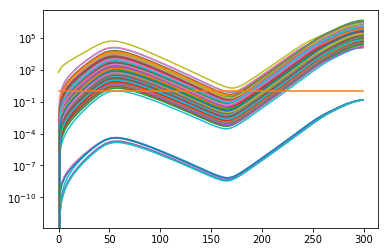

In [43]:
plt.plot(np.mean(plotdata[len(nodes):2*len(nodes),:,:],axis=2).T)
plt.plot(np.ones(300))
plt.semilogy()
plt.show()

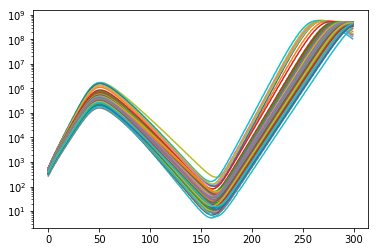

In [41]:
plt.plot(np.sum(plotdata[:2*len(nodes),:,:],axis=0))
plt.semilogy()
plt.show()

In [15]:
def pltdata(cname, t):
    # cname: city name
    # t: time
    idx = nodes[cname] # index
    nl = len(nodes) # node length
    popu = city_properties[cname]['pop']
    prov = city_properties[cname]['prov']
    
    # 感染、确诊、易感
    # index,cityname,citypopu,cityprov,time,
    # infe, infe_l, infe_h,
    # conf, conf_l, conf_h,
    # susp, susp_l, susp_h
    basicdata = [0, cname, popu, prov, t]
    infs = ReportData(plotdata[idx, t])
    confs = ReportData(plotdata[nl+idx, t])
    susps = ReportData(plotdata[2*nl+idx, t])
    infconf = ReportData(plotdata[idx, t]+plotdata[nl+idx, t])
    return basicdata + infs + confs+susps + infconf

### Compute MAE

In [32]:
maes=[]
mapes=[]

for city,i in nodes.items():
    itm = all_cases.get(city, [])
    if len(itm)==0:
        itm = all_cases.get(city[:-1], [])
    if len(itm)>0:
        times = itm[0]
        confirmed = itm[1] - itm[2] - itm[3]
        mae = []
        mape = []
        count = 0
        for j,time in enumerate(times):
            real = confirmed[j]
            if real > 0:
                predict = result[int(time / interval), len(nodes)+i] * city_properties[city]['pop']
                mae.append(np.abs(real - predict))
                mape.append(np.abs(real - predict) / real)
                count += 1
                #print(mape)
                if real == 0:
                    print(itm)
                    print(confirmed[j])
                    print(j)
        if count > 0:
            maes.append(np.mean(mae))
            mapes.append(np.mean(mape))


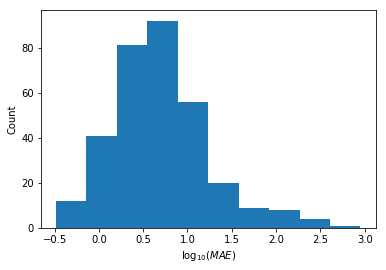

In [34]:
plt.hist(np.log10(maes))
#plt.hist(mapes)
plt.xlabel('$\log_{10}(MAE)$')
plt.ylabel('Count')
plt.show()

In [33]:
np.mean(maes), np.std(maes) / np.sqrt(len(nodes)) * 1.96

(16.5716026154312, 6.573720206900261)

### Confirmed population at different days

In [29]:
# 确诊人数
for tt in [10, 17, 24, 31, 38]:
    print(tt, '========')
    #tt=10# Feb 7: 38
    ReportInt(plotdata[len(nodes)+nodes['武汉市'], tt-1], 'wuhan: ')
    Report(plotdata[len(nodes)+nodes['上海市'], tt-1], 'shanghai: ', 2)
    ReportInt(np.sum(plotdata[len(nodes):2*len(nodes), tt-1], axis=0), 'China: ')

10 ========
wuhan: [521, 503] (325-421-605-796)
shanghai: [1.29, 1.31] (0.99-1.29-1.33-1.37)
China: [646, 631] (452-548-734-893)
17 ========
wuhan: [1330, 1247] (724-1005-1564-2433)
shanghai: [7.6, 7.66] (6.67-7.58-7.73-7.86)
China: [2032, 1957] (1381-1693-2294-3058)
24 ========
wuhan: [3244, 2936] (1558-2281-3817-7129)
shanghai: [31.72, 31.81] (29.81-31.09-32.48-33.15)
China: [6038, 5740] (4015-4948-6766-10074)
31 ========
wuhan: [7906, 6833] (3314-5148-9222-20294)
shanghai: [114.75, 114.22] (102.93-109.76-119.29-129.28)
China: [17575, 16408] (11251-14078-19535-32420)
38 ========
wuhan: [18091, 14883] (6691-10913-20719-52415)
shanghai: [356.43, 351.14] (301.31-331.75-372.0-454.46)
China: [46948, 43108] (28917-36602-51760-93492)


### Export to as the plot data

In [96]:
title=['index','cityname','citypopu','cityprov','time',
        'infe', 'infe_l', 'infe_h',
        'conf', 'conf_l', 'conf_h',
        'susp', 'susp_l', 'susp_h',
        'inf+conf', 'inf+conf_l', 'inf+conf_h',
      ]

exportplotdata = []
exportplotdata.append(title)
for cname in nodes.keys():
    for t in range(200):
        #print(cname)
        #print(pltdata(cname, t))
        exportplotdata.append(pltdata(cname, t))
for i in range(len(exportplotdata) - 1):
    exportplotdata[i+1][0] = i

import csv

with open('./data/plot_data_early_slow_cities.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(exportplotdata)

### no intervention:

In [17]:
v=jan_07
ReportInt(v, 'wuhan Jan 7: ')

v = wuhan
ReportInt(v, 'wuhan\t\t ')

v = huanggang
ReportInt(v, 'huanggang\t ')

v = chongqing
ReportInt(v, 'chongqing\t ')

v = shanghai
ReportInt(v, 'shanghai\t ')

v = cum_all
ReportInt(v, 'total infect\t ')
Report(np.array(v)/1e9, 'total infect\t ',4)

v = country
ReportInt(v, 'country max\t ')

v = cum_death
ReportInt(v, 'total death\t ')
Report(np.array(v)/1e9, 'total death\t ',4)

v = cum_confirm
ReportInt(v, 'total confirm\t ')
Report(np.array(v)/1e9, 'total confirm\t ',4)

print('Jan 25:=====')
# Jan. 25, 2020
v = wuhan25
ReportInt(v, 'Wuhan: ')

v = shanghai25
ReportInt(v, 'Shanghai: ')

v = beijing25
ReportInt(v, 'Beijing: ')

v = guangzhou25
ReportInt(v, 'Guangzhou: ')


print('Mar 4:======')
v = wuhan4
ReportInt(v, 'Wuhan: ')

v = shanghai4
ReportInt(v, 'Shanghai: ')

v = beijing4
ReportInt(v, 'Beijing: ')

v = guangzhou4
ReportInt(v, 'Guangzhou: ')


print('Total inf:=====')
v = np.array(city_cum)[:, nodes['武汉市']]*city_properties['武汉市']['pop']
ReportInt(v, 'Wuhan Total Inf.: ')
ReportInt(v*death_ratio, 'total death: ')

v = np.array(city_cum)[:, nodes['黄冈市']]*city_properties['黄冈市']['pop']
ReportInt(v, 'Huanggang Total Inf.: ')
Report(v*death_ratio, 'total death: ',2)

v = np.array(city_cum)[:, nodes['重庆市']]*city_properties['重庆市']['pop']
ReportInt(v, 'Chongqing Total Inf.: ')
Report(v*death_ratio, 'total death: ',2)

v = np.array(city_cum)[:, nodes['上海市']]*city_properties['上海市']['pop']
ReportInt(v, 'Shanghai Total Inf.: ')
Report(v*death_ratio, 'total death: ',2)

wuhan Jan 7: [1161, 1138] (733-972-1347-1675)
wuhan		 [3606740, 3603909] (3149806-3476867-3729595-4057082)
huanggang	 [2086858, 2086091] (1824794-2014948-2156590-2341654)
chongqing	 [10333431, 10341738] (9064714-9990037-10674626-11554892)
shanghai	 [8145281, 8149047] (7147801-7872539-8412533-9117323)
total infect	 [1182444865, 1180451880] (1160072370-1173376730-1188786380-1220233414)
total infect	 [1.1824, 1.1805] (1.1601-1.1734-1.1888-1.2202)
country max	 [460187299, 461361443] (404797776-445304125-475093540-508583304)
total death	 [27196232, 27150393] (26681665-26987665-27342087-28065369)
total death	 [0.0272, 0.0272] (0.0267-0.027-0.0273-0.0281)
total confirm	 [1085171349, 1117449838] (845380912-1037069808-1156169240-1195085060)
total confirm	 [1.0852, 1.1174] (0.8454-1.0371-1.1562-1.1951)
Jan 25:=====
Wuhan: [11581, 10318] (5111-8219-13513-25997)
Shanghai: [144, 143] (127-137-149-170)
Beijing: [112, 112] (97-106-116-130)
Guangzhou: [79, 77] (71-75-82-97)
Mar 4:======
Wuhan: [123287

In [158]:
import csv

def savelist(filename, dlist):
    with open('./data/'+filename, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(dlist)

In [162]:
savelist('wuhan_max_no_inter.csv', [wuhan])
savelist('all_inf_no_inter.csv', [cum_all])
savelist('wuhan_25_no_inter.csv', [wuhan25])

### baseline:

In [164]:
savelist('wuhan_max_base.csv', [wuhan])
savelist('all_inf_no_base.csv', [cum_all])
savelist('wuhan_25_no_base.csv', [wuhan25])

In [30]:
v=jan_07
ReportInt(v, 'wuhan Jan 7: ')

v = wuhan
ReportInt(v, 'wuhan\t\t ')

v = huanggang
ReportInt(v, 'huanggang\t ')

v = chongqing
ReportInt(v, 'chongqing\t ')

v = shanghai
ReportInt(v, 'shanghai\t ')

v = cum_all
ReportInt(v, 'total infect\t ')
Report(np.array(v)/1e9, 'total infect\t ',4)

v = country
ReportInt(v, 'country max\t ')

v = cum_death
ReportInt(v, 'total death\t ')
Report(np.array(v)/1e9, 'total death\t ',4)

v = cum_confirm
ReportInt(v, 'total confirm\t ')
Report(np.array(v)/1e9, 'total confirm\t ',4)

print('Jan 25:=====')
# Jan. 25, 2020
v = wuhan25
ReportInt(v, 'Wuhan: ')

v = shanghai25
ReportInt(v, 'Shanghai: ')

v = beijing25
ReportInt(v, 'Beijing: ')

v = guangzhou25
ReportInt(v, 'Guangzhou: ')


print('Mar 4:======')
v = wuhan4
ReportInt(v, 'Wuhan: ')

v = shanghai4
ReportInt(v, 'Shanghai: ')

v = beijing4
ReportInt(v, 'Beijing: ')

v = guangzhou4
ReportInt(v, 'Guangzhou: ')


print('Total inf:=====')
v = np.array(city_cum)[:, nodes['武汉市']]*city_properties['武汉市']['pop']
ReportInt(v, 'Wuhan Total Inf.: ')
ReportInt(v*death_ratio, 'total death: ')

v = np.array(city_cum)[:, nodes['黄冈市']]*city_properties['黄冈市']['pop']
ReportInt(v, 'Huanggang Total Inf.: ')
Report(v*death_ratio, 'total death: ',2)

v = np.array(city_cum)[:, nodes['重庆市']]*city_properties['重庆市']['pop']
ReportInt(v, 'Chongqing Total Inf.: ')
Report(v*death_ratio, 'total death: ',2)

v = np.array(city_cum)[:, nodes['上海市']]*city_properties['上海市']['pop']
ReportInt(v, 'Shanghai Total Inf.: ')
Report(v*death_ratio, 'total death: ',2)

wuhan Jan 7: [1161, 1138] (733-972-1347-1675)
wuhan		 [59772, 47914] (20537-36089-66658-176147)
huanggang	 [13117, 12543] (7464-10680-14733-22938)
chongqing	 [1772, 1751] (1423-1631-1864-2251)
shanghai	 [1541, 1521] (1234-1414-1624-1977)
total infect	 [302944, 278137] (173553-235491-336302-604469)
total infect	 [0.0003, 0.0003] (0.0002-0.0002-0.0003-0.0006)
country max	 [178887, 164768] (106777-141930-194832-348530)
total death	 [6968, 6397] (3992-5416-7735-13903)
total death	 [0.0, 0.0] (0.0-0.0-0.0-0.0)
total confirm	 [255694, 232676] (154390-196810-280209-522720)
total confirm	 [0.0003, 0.0002] (0.0002-0.0002-0.0003-0.0005)
Jan 25:=====
Wuhan: [11566, 10306] (5104-8209-13497-25963)
Shanghai: [144, 143] (127-137-149-170)
Beijing: [111, 111] (97-106-116-130)
Guangzhou: [79, 77] (71-75-82-96)
Mar 4:======
Wuhan: [12021, 9146] (3791-6498-13270-36072)
Shanghai: [448, 435] (336-401-478-648)
Beijing: [334, 323] (245-295-357-500)
Guangzhou: [276, 272] (220-254-292-360)
Total inf:=====
Wuhan

### early warning:

In [53]:
v=jan_07
ReportInt(v, 'wuhan Jan 7: ')

v = wuhan
ReportInt(v, 'wuhan\t\t ')

v = huanggang
ReportInt(v, 'huanggang\t ')

v = chongqing
ReportInt(v, 'chongqing\t ')

v = shanghai
ReportInt(v, 'shanghai\t ')

v = cum_all
ReportInt(v, 'total infect\t ')
Report(np.array(v)/1e9, 'total infect\t ',4)

v = country
ReportInt(v, 'country max\t ')

v = cum_death
ReportInt(v, 'total death\t ')
Report(np.array(v)/1e9, 'total death\t ',4)

v = cum_confirm
ReportInt(v, 'total confirm\t ')
Report(np.array(v)/1e9, 'total confirm\t ',4)

print('Jan 25:=====')
# Jan. 25, 2020
v = wuhan25
ReportInt(v, 'Wuhan: ')

v = shanghai25
ReportInt(v, 'Shanghai: ')

v = beijing25
ReportInt(v, 'Beijing: ')

v = guangzhou25
ReportInt(v, 'Guangzhou: ')


print('Mar 4:======')
v = wuhan4
ReportInt(v, 'Wuhan: ')

v = shanghai4
ReportInt(v, 'Shanghai: ')

v = beijing4
ReportInt(v, 'Beijing: ')

v = guangzhou4
ReportInt(v, 'Guangzhou: ')


print('Total inf:=====')
v = np.array(city_cum)[:, nodes['武汉市']]*city_properties['武汉市']['pop']
ReportInt(v, 'Wuhan Total Inf.: ')
ReportInt(v*death_ratio, 'total death: ')

v = np.array(city_cum)[:, nodes['黄冈市']]*city_properties['黄冈市']['pop']
ReportInt(v, 'Huanggang Total Inf.: ')
Report(v*death_ratio, 'total death: ',2)

v = np.array(city_cum)[:, nodes['重庆市']]*city_properties['重庆市']['pop']
ReportInt(v, 'Chongqing Total Inf.: ')
Report(v*death_ratio, 'total death: ',2)

v = np.array(city_cum)[:, nodes['上海市']]*city_properties['上海市']['pop']
ReportInt(v, 'Shanghai Total Inf.: ')
Report(v*death_ratio, 'total death: ',2)

wuhan Jan 7: [1161, 1138] (733-972-1347-1675)
wuhan		 [16293, 13977] (6535-10911-18802-40437)
huanggang	 [2792, 2778] (1874-2450-3106-3868)
chongqing	 [326, 327] (280-309-342-377)
shanghai	 [285, 286] (243-269-299-334)
total infect	 [68307, 64756] (41270-54964-76852-120930)
total infect	 [0.0001, 0.0001] (0.0-0.0001-0.0001-0.0001)
country max	 [39361, 37196] (24953-32401-43643-67985)
total death	 [1571, 1489] (949-1264-1768-2781)
total death	 [0.0, 0.0] (0.0-0.0-0.0-0.0)
total confirm	 [55971, 52254] (35596-44998-62088-101563)
total confirm	 [0.0001, 0.0001] (0.0-0.0-0.0001-0.0001)
Jan 25:=====
Wuhan: [10908, 9727] (4820-7756-12740-24381)
Shanghai: [135, 134] (120-129-140-159)
Beijing: [105, 105] (91-100-109-122)
Guangzhou: [74, 73] (67-71-77-91)
Mar 4:======
Wuhan: [1229, 1007] (424-719-1418-3123)
Shanghai: [39, 38] (29-35-42-50)
Beijing: [29, 29] (21-26-31-38)
Guangzhou: [24, 23] (19-22-25-29)
Total inf:=====
Wuhan Total Inf.: [29006, 25759] (12575-20378-33878-65794)
total death: [66

### servere:

In [231]:
v=jan_07
ReportInt(v, 'wuhan Jan 7: ')

v = wuhan
ReportInt(v, 'wuhan\t\t ')

v = huanggang
ReportInt(v, 'huanggang\t ')

v = chongqing
ReportInt(v, 'chongqing\t ')

v = shanghai
ReportInt(v, 'shanghai\t ')

v = cum_all
ReportInt(v, 'total infect\t ')
Report(np.array(v)/1e6, 'total infect\t ',4)

v = country
ReportInt(v, 'country max\t ')

v = cum_death
ReportInt(v, 'total death\t ')
Report(np.array(v)/1e6, 'total death\t ',4)

v = cum_confirm
ReportInt(v, 'total confirm\t ')
Report(np.array(v)/1e6, 'total confirm\t ',4)

print('Jan 25:=====')
# Jan. 25, 2020
v = wuhan25
ReportInt(v, 'Wuhan: ')

v = shanghai25
ReportInt(v, 'Shanghai: ')

v = beijing25
ReportInt(v, 'Beijing: ')

v = guangzhou25
ReportInt(v, 'Guangzhou: ')


print('Mar 4:======')
v = wuhan4
ReportInt(v, 'Wuhan: ')

v = shanghai4
ReportInt(v, 'Shanghai: ')

v = beijing4
ReportInt(v, 'Beijing: ')

v = guangzhou4
ReportInt(v, 'Guangzhou: ')


print('Total inf:=====')
v = np.array(city_cum)[:, nodes['武汉市']]*city_properties['武汉市']['pop']
ReportInt(v, 'Wuhan Total Inf.: ')
ReportInt(v*death_ratio, 'total death: ')

v = np.array(city_cum)[:, nodes['黄冈市']]*city_properties['黄冈市']['pop']
ReportInt(v, 'Huanggang Total Inf.: ')
ReportInt(v*death_ratio, 'total death: ')

v = np.array(city_cum)[:, nodes['重庆市']]*city_properties['重庆市']['pop']
ReportInt(v, 'Chongqing Total Inf.: ')
ReportInt(v*death_ratio, 'total death: ')

v = np.array(city_cum)[:, nodes['上海市']]*city_properties['上海市']['pop']
ReportInt(v, 'Shanghai Total Inf.: ')
ReportInt(v*death_ratio, 'total death: ')

wuhan Jan 7: [1170, 1143] (758-982-1361-1675)
wuhan		 [358063, 271337] (118579-195916-397939-1150361)
huanggang	 [113152, 99041] (54697-80486-125586-256793)
chongqing	 [20112, 19163] (14121-17254-20949-32491)
shanghai	 [17479, 16652] (12323-15004-18158-28310)
total infect	 [3032531, 2738222] (1681473-2306353-3283727-6512208)
total infect	 [3.0325, 2.7382] (1.6815-2.3064-3.2837-6.5122)
country max	 [1585423, 1404554] (923650-1206336-1699167-3355589)
total death	 [69748, 62979] (38674-53046-75526-149781)
total death	 [0.0697, 0.063] (0.0387-0.053-0.0755-0.1498)
total confirm	 [2658018, 2320576] (1563309-1950397-2849074-5932460)
total confirm	 [2.658, 2.3206] (1.5633-1.9504-2.8491-5.9325)
Jan 25:=====
Wuhan: [11763, 10358] (5474-8246-13680-25949)
Shanghai: [144, 143] (128-137-149-171)
Beijing: [112, 112] (97-106-116-131)
Guangzhou: [79, 77] (71-75-82-97)
Mar 4:======
Wuhan: [321910, 243680] (106609-175335-360745-1031804)
Shanghai: [17122, 16234] (12011-14632-17797-27877)
Beijing: [12678, 

### China total infection, confirmation

In [92]:
inf = np.median(np.sum(plotdata[:len(nodes), :, :], axis=0), axis=1)
inflow = np.quantile(np.sum(plotdata[:len(nodes), :, :], axis=0), 0.025, axis=1)
infhigh = np.quantile(np.sum(plotdata[:len(nodes), :, :], axis=0), 1-0.025, axis=1)

conf = np.median(np.sum(plotdata[len(nodes):2*len(nodes), :, :], axis=0), axis=1)
conflow = np.quantile(np.sum(plotdata[len(nodes):2*len(nodes), :, :], axis=0), 0.025, axis=1)
confhigh = np.quantile(np.sum(plotdata[len(nodes):2*len(nodes), :, :], axis=0), 1-0.025, axis=1)

allinf = np.median(np.sum(plotdata[:2*len(nodes), :, :], axis=0), axis=1)
allinflow = np.quantile(np.sum(plotdata[:2*len(nodes), :, :], axis=0), 0.025, axis=1)
allinfhigh = np.quantile(np.sum(plotdata[:2*len(nodes), :, :], axis=0), 1-0.025, axis=1)

chinaplotdata = np.array([range(200), inf, inflow, infhigh, conf, \
          conflow, confhigh, allinf, allinflow, allinfhigh]).T
chinaplotdata = chinaplotdata.tolist()
chinaplotdata = [['day','infected', 'inf. low', 'inf. high', \
 'confirm', 'con. low', 'con. high', \
 'inf+con', 'i.c.low','i.c.high']] + chinaplotdata

with open('./data/plot_china_early_slow.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(chinaplotdata)

## Varying t0

Show how death population change if we can act earlier.

In [149]:
t0s=np.linspace(1,22,10)
#t_i = 9.2#10#1/0.0134#6 #serial interval，参考SARS
#t_l = 8.3#8.89 #一个病患潜伏期时间，参考SARS、MERS
gamma = 0.03#flowing_ratio
eta = 1
t_m = 35
timespan = np.linspace(0, 200, 1000)
interval = 200 / 1000
ls0 = np.zeros(len(nodes))
js0 = np.zeros(len(nodes))
ss0 = np.ones(len(nodes))
ls0[nodes['武汉市']] = float(initial_latent)/float(city_properties['武汉市']['pop'])#1e-4
js0[nodes['武汉市']] = float(first_cases)/float(city_properties['武汉市']['pop'])
ss0[nodes['武汉市']] = 1-ls0[nodes['武汉市']]-js0[nodes['武汉市']]
results_cum=[]
results_death=[]
for t_0 in t0s:
    flushPrint(t_0)
    cum_all=[]
    cum_death=[]
    for best_para in experiments:
        fit_param = sorted([(vvv[1],i) for i,vvv in enumerate(best_para)])
        itm = best_para[fit_param[0][1]]
        r0 = itm[0][0][0].item()
        initial_latent = itm[0][0][1].item()
        alpha = itm[0][0][2].item()
        t_i = itm[2][0]#10#1/0.0134#6 #serial interval，参考SARS
        t_l = itm[2][1]#8.89 #一个病患潜伏期时间，参考SARS、MERS
        gamma = itm[2][2]#0.03#flowing_ratio

        result = odeint(diff, np.r_[ls0,js0,ss0], timespan, args = (r0, t_i, t_l, alpha, gamma, eta, 
                                                                 t_m, t_0, pij,True))
        all_pop = np.zeros([result.shape[0]])
        all_confirmed = np.zeros([result.shape[0]])
        all_recovery = np.zeros([result.shape[0]])
        for k,city in city_properties.items():
            idx = nodes[k]
            all_pop += (result[:, idx]+result[:, len(nodes)+idx]) * city['pop']
            all_confirmed += (result[:, len(nodes)+idx]) * city['pop']
            all_recovery += (1-result[:, len(nodes)+idx]-result[:,idx]-result[:,2*len(nodes)+idx]) * city['pop']
        cum_all.append(np.max(all_recovery))
        cum_death.append(np.max(all_recovery * death_ratio))
        results_cum.append([t_0, np.max(all_recovery)])
        results_death.append([t_0, np.max(all_recovery * death_ratio)])
    #results_cum.append([t_0, np.mean(cum_all)])
    #results_death.append([t_0, np.mean(cum_death)])

22.066666666666668

In [233]:
from scipy import stats
fitdata=np.array(results_death).reshape(10, -1, 2).transpose(1,0,2)
slopes = []
for i in range(10):
    slope = stats.linregress(fitdata[i,:,0],np.log2(fitdata[i,:,1]))[0]
    slopes.append(slope)
Report(slopes, 'slopes: ', 3)

slopes: [0.213, 0.212] (0.208-0.211-0.214-0.219)


## Relaxation

Finding the safe relaxation date.

In [62]:
t_0 = 22
#t_i = 9.2#10#1/0.0134#6 #serial interval，参考SARS
#t_l = 8.3#8.89 #一个病患潜伏期时间，参考SARS、MERS
#gamma = 0.03#flowing_ratio
eta = 1
t_m = 35
#relax = 88
timespan = np.linspace(0, 400, 1000)
interval = 400 / 1000
ls0 = np.zeros(len(nodes))
js0 = np.zeros(len(nodes))
ss0 = np.ones(len(nodes))

relaxx = []
relax_confirmed = []
for relax in range(80, 110):#(60, 90):#60-90
    for best_para in experiments:
        fit_param = sorted([(vvv[1],i) for i,vvv in enumerate(best_para)])
        itm = best_para[fit_param[0][1]]
        r0 = itm[0][0][0].item()
        initial_latent = itm[0][0][1].item()
        alpha = itm[0][0][2].item()
        t_i = itm[2][0]#10#1/0.0134#6 #serial interval，参考SARS
        t_l = itm[2][1]#8.89 #一个病患潜伏期时间，参考SARS、MERS
        gamma = itm[2][2]#0.03#flowing_ratio
        t_m, t_0, interQ = scenarios['early_slow']
        
        ls0[nodes['武汉市']] = float(initial_latent)/float(city_properties['武汉市']['pop'])#1e-4
        js0[nodes['武汉市']] = float(first_cases)/float(city_properties['武汉市']['pop'])
        ss0[nodes['武汉市']] = 1-ls0[nodes['武汉市']]-js0[nodes['武汉市']]
        cum_inf_conf = np.zeros(len(nodes))

        result = odeint(diff, np.r_[ls0,js0,ss0], timespan, args = (r0, t_i, t_l, alpha, gamma, eta, 
                                                                 t_m, t_0, pij,True,relax))
        number = 0
        all_pop = np.zeros([result.shape[0]])
        all_confirmed = np.zeros([result.shape[0]])
        all_recovery = np.zeros([result.shape[0]])            
        for city,c in nodes.items():
            rr = result[:,nodes[city]]*city_properties[city]['pop']
            all_pop += (result[:, c]+result[:, len(nodes)+c]) * city_properties[city]['pop']
            all_confirmed += (result[:, len(nodes)+c]) * city_properties[city]['pop']
            #print(2*len(nodes)+c)
            #print('idx',idx)
            all_recovery += (1-result[:, len(nodes)+c]-result[:,c]-
                             result[:,2*len(nodes)+c]) * city_properties[city]['pop']
            bb = np.nonzero((rr<1)&(timespan>relax)&(timespan<250))
            if len(bb[0])>0:
                number += 1 #人数小于1的城市数
        if number == len(nodes): #若所有城市都小于1，则存储当前日期以及确诊人数
            relaxx.append(relax)
            c = all_confirmed[int(relax / interval)]
            relax_confirmed.append(c)

In [63]:
min(relaxx)

88

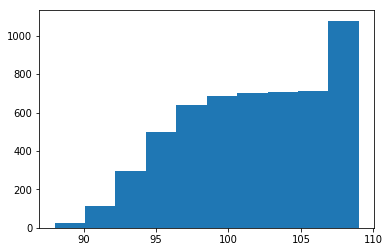

In [64]:
plt.hist(relaxx)
plt.show()

In [65]:
#bools = np.array(relaxx) == min(relaxx)
bools = np.array(relaxx) == np.quantile(relaxx, 0.05)
relax_result = np.array(relax_confirmed)[bools]

print(np.quantile(relaxx, 0.05))

v=relax_result
ReportInt(v, 'relaxation: ')

94.0
relaxation: [9119, 9105] (5804-8016-10318-12006)


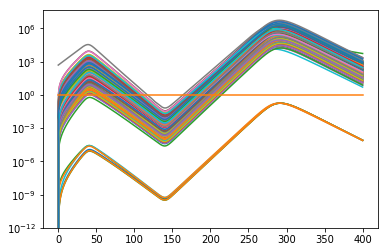

In [100]:
best_para=experiments[1]
fit_param = sorted([(vvv[1],i) for i,vvv in enumerate(best_para)])
itm = best_para[fit_param[0][1]]
r0 = itm[0][0][0].item()
initial_latent = itm[0][0][1].item()
alpha = itm[0][0][2].item()

result = odeint(diff, np.r_[ls0,js0,ss0], timespan, args = (r0, t_i, t_l, alpha, gamma, eta, 
                                                         t_m, t_0, pij,True,90)) #81
number = 0
rall = np.zeros(1000)
for city,c in nodes.items():
    rr = result[:,nodes[city]]*city_properties[city]['pop']
    rall += rr
    dd = np.abs(np.diff(rr))
    bb = np.nonzero((rr<1)&(timespan>relax)&(timespan<400))
    if len(bb[0])>0:
        number += 1
    plt.semilogy(timespan, rr)
plt.plot(timespan, np.ones(len(timespan)))
plt.show()

In [168]:
conf_alls = []
timespan = np.linspace(0, 400, 1000)
interval = 400 / 1000
for best_para in experiments:
    #best_para=experiments[1]
    fit_param = sorted([(vvv[1],i) for i,vvv in enumerate(best_para)])
    itm = best_para[fit_param[0][1]]
    r0 = itm[0][0][0].item()
    initial_latent = itm[0][0][1].item()
    alpha = itm[0][0][2].item()
    t_m, t_0, interQ = scenarios['baseline']
    
    ls0 = np.zeros(len(nodes))
    js0 = np.zeros(len(nodes))
    ss0 = np.ones(len(nodes))
    ls0[nodes['武汉市']] = float(initial_latent)/float(city_properties['武汉市']['pop'])#1e-4
    js0[nodes['武汉市']] = float(first_cases)/float(city_properties['武汉市']['pop'])
    ss0[nodes['武汉市']] = 1-ls0[nodes['武汉市']]-js0[nodes['武汉市']]

    result = odeint(diff, np.r_[ls0,js0,ss0], timespan, args = (r0, t_i, t_l, alpha, gamma, eta, 
                                                             t_m, t_0, pij,True,95)) #81
    number = 0
    rall = np.zeros(1000)
    for city,c in nodes.items():
        rr = result[:,nodes[city]]*city_properties[city]['pop']
        rall += rr
        dd = np.abs(np.diff(rr))
        bb = np.nonzero((rr<1)&(timespan>relax)&(timespan<400))
        if len(bb[0])>0:
            number += 1
    conf_alls.append(rall)

In [169]:
median90=[np.median(confs) for confs in np.array(conf_alls).T]
low90=[np.quantile(confs,0.025) for confs in np.array(conf_alls).T]
high90=[np.quantile(confs,1-0.025) for confs in np.array(conf_alls).T]

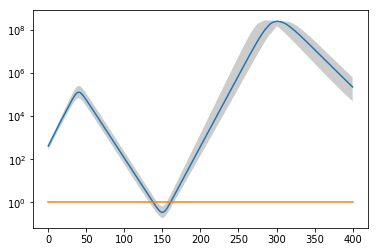

In [170]:
plt.plot(timespan, median90)
plt.fill_between(timespan, low90, high90, alpha=0.2, facecolor='#000000')
#plt.plot(timespan, low90)
#plt.plot(timespan, high90)
plt.plot(timespan, np.ones(len(timespan)))
plt.semilogy()
plt.show()

In [171]:
import csv

with open('90days.csv','w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(np.array([median90,low90,high90]).T)
